TODO:  
- Test with different order values
- Error handling

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.preprocessing import MinMaxScaler
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, activations, regularizers
import time
import warnings

data = pandas.read_csv('../Datasets/AirQualityUCI/AirQualityUCI.csv', sep='\t')
data = data.drop(columns=['Date', 'Time'])
split = 800
all_performances = {}
all_times = {}

In [2]:
small_data = data.iloc[:1000]

results = {}
times = {}

values = small_data.values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# Receives a time series dataset and creates training, test and, optionally, validation sets
# data: dataset
# order: number of previous timesteps to be included in the input (0 or higher)
# split: index that separates training and test sets
# val_split: size of validation set (0 or higher)
# step: offset between x and y values (1 or higher)
def series_to_supervised(data, order, split, val_split=0, step=1):
  df = pandas.DataFrame(data)
  for col in df.columns:
    df = df.rename(columns = {col: 'var' + str(col)})
  df_shift = df.shift(-step).dropna()

  if val_split == 0:
    val_x_split = -len(df)
    val_y_split = -len(df_shift)
    warnings.warn("x_val and y_val are empty DataFrames.")
  else:
    val_x_split = val_split
    val_y_split = val_split

  y_train = df_shift[df_shift.columns][:split]
  y_test = df_shift[df_shift.columns][split:-val_y_split]
  y_val = df_shift[df_shift.columns][-val_y_split:]

  shifts = {}

  if order > 0:
    for i in range(1, order + 1):
      shifts['-' + str(i)] = df.shift(i)
  for key in shifts.keys():
    for col in shifts[key].columns:
      df[str(col) + key] = shifts[key][col]

  df = df.drop(df.index[-step:])
  x_train = df[df.columns][:split]
  x_test = df[df.columns][split:-val_x_split]
  x_val = df[df.columns][-val_x_split:]

  x_train = x_train.fillna(0)
  x_test = x_test.fillna(0)

  return x_train, x_test, y_train, y_test, x_val, y_val

In [3]:
def mean_absolute_error(expt, obs):
  n = 0
  total = 0
  for i in range(len(expt)):
    n += len(expt[i])
    for j in range(len(expt[i])):
      total += abs(expt[i][j] - obs[i][j])
  return total / n

In [4]:
# Creates a Dictionary of a new row
def generate_row(cols, vals):
  output = {}
  for i in range(len(cols)):
    output[cols[i]] = vals[i]
  return output

# Removes first row of a dataframe and appends a new one
def shift_rows(df, new_row):
  df = df.drop(df.index[0])
  row = generate_row(df.columns, new_row)
  df = df.append(row, ignore_index=True)
  return df

# Shifts input step with predicted values for the Recursive Strategy
def shift_input(arr, pred):
  arr = arr[:, :, :-len(pred)]
  output = np.append(pred, arr)
  return np.reshape(output, (1, 1, len(output)))

Recursive Strategy  
- One Model is trained  
- Predicted values are used as input for further Forecasting

In [5]:
times = np.zeros(10)
performances = np.zeros(10)

for i in range(10):
  print("Iteration", i)
  start_time = time.perf_counter()

  x_train, x_test, y_train, y_test, x_val, y_val = series_to_supervised(scaled, 5, split, 10)

  x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
  x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
  y_train = y_train.values
  y_test = y_test.values

  keras.backend.clear_session()

  lstm_model = keras.models.Sequential([
      layers.Bidirectional(layers.LSTM(20, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.RepeatVector(1),
      layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.Dropout(0.2),
      layers.TimeDistributed(layers.Dense(y_train.shape[-1]))
  ])
  lstm_model.compile(loss='mae', optimizer='adam')
  lstm_history = lstm_model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), shuffle=False)

  outputs = []

  # Reshape input to be compatible with the model
  initial = np.reshape(x_val.iloc[0].values, (1, 1, x_val.iloc[0].values.shape[0]))

  for j in range(10):
    # Obtain model's prediction of the input
    output = lstm_model.predict(initial)
    
    # Save output to outputs array
    outputs.append(output[0, 0])

    # Remove first row of input and add the new prediction
    initial = shift_input(initial, output[0, 0])

  end_time = time.perf_counter() - start_time

  performances[i] = mean_absolute_error(y_val.values, outputs)
  times[i] = end_time

Iteration 0
Epoch 1/50
160/160 [==============================] - 11s 23ms/step - loss: 0.2918 - val_loss: 0.3279
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2056 - val_loss: 0.2768
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1820 - val_loss: 0.2406
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1716 - val_loss: 0.2081
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1585 - val_loss: 0.1590
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1503 - val_loss: 0.1396
Epoch 7/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1456 - val_loss: 0.1245
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1425 - val_loss: 0.1520
Epoch 9/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1405 - val_loss: 0.1570
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1

160/160 [==============================] - 2s 10ms/step - loss: 0.1194 - val_loss: 0.1401
Epoch 32/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1196 - val_loss: 0.1384
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1184 - val_loss: 0.1324
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1164 - val_loss: 0.1518
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1178 - val_loss: 0.1399
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1163 - val_loss: 0.1350
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1159 - val_loss: 0.1502
Epoch 38/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1157 - val_loss: 0.1394
Epoch 39/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1156 - val_loss: 0.1591
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1157 - val_loss: 0

160/160 [==============================] - 3s 18ms/step - loss: 0.1432 - val_loss: 0.1843
Epoch 12/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1383 - val_loss: 0.1940
Epoch 13/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1378 - val_loss: 0.1762
Epoch 14/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1361 - val_loss: 0.1545
Epoch 15/50
160/160 [==============================] - 4s 26ms/step - loss: 0.1343 - val_loss: 0.1563
Epoch 16/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1337 - val_loss: 0.1707
Epoch 17/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1327 - val_loss: 0.1525
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1297 - val_loss: 0.1657
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1301 - val_loss: 0.1724
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1323 - val_loss:

160/160 [==============================] - 2s 10ms/step - loss: 0.1146 - val_loss: 0.1271
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1172 - val_loss: 0.1505
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1153 - val_loss: 0.1454
Epoch 44/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1171 - val_loss: 0.1647
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1138 - val_loss: 0.1383
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1144 - val_loss: 0.1549
Epoch 47/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1140 - val_loss: 0.1378
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1134 - val_loss: 0.1298
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1111 - val_loss: 0.1403
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1113 - val_loss: 0.

160/160 [==============================] - 1s 9ms/step - loss: 0.1294 - val_loss: 0.1781
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1308 - val_loss: 0.1437
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1267 - val_loss: 0.1608
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1269 - val_loss: 0.1656
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1262 - val_loss: 0.1622
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1261 - val_loss: 0.1259
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1245 - val_loss: 0.1609
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1255 - val_loss: 0.1422
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1234 - val_loss: 0.1733
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1252 - val_loss: 0.1688


160/160 [==============================] - 10s 21ms/step - loss: 0.2801 - val_loss: 0.3293
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2075 - val_loss: 0.3201
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1882 - val_loss: 0.2687
Epoch 4/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1735 - val_loss: 0.2436
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1629 - val_loss: 0.1925
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1528 - val_loss: 0.1730
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1502 - val_loss: 0.1668
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1473 - val_loss: 0.1483
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1459 - val_loss: 0.1686
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1427 - val_loss: 0.1637
Epoch

160/160 [==============================] - 2s 11ms/step - loss: 0.1234 - val_loss: 0.1717
Epoch 32/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1213 - val_loss: 0.1683
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1206 - val_loss: 0.1830
Epoch 34/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1187 - val_loss: 0.1377
Epoch 35/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1161 - val_loss: 0.1419
Epoch 36/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1167 - val_loss: 0.1188
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1166 - val_loss: 0.1333
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1164 - val_loss: 0.1191
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1164 - val_loss: 0.1397
Epoch 40/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1153 - val_loss:

In [6]:
print("Average Training Time:", np.average(times))
print("Average Mean Absolute Error:", np.average(performances))
print("Standard Deviation of Training Times:", math.sqrt(np.var(times)))
print("Standard Deviation of Mean Absolute Error:", math.sqrt(np.var(performances)))

all_times['recursive'] = ((np.average(times), math.sqrt(np.var(times))))
all_performances['recursive'] = ((np.average(performances), math.sqrt(np.var(performances))))

Average Training Time: 146.12748794990003
Average Mean Absolute Error: 0.23966662021067972
Standard Deviation of Training Times: 18.129380340551016
Standard Deviation of Mean Absolute Error: 0.06623139120295822


Direct Strategy  
 - N models are trained for N predicted values
 - A given model predicts the value after k time steps    
 - All models use the same input

In [7]:
times = np.zeros(10)
performances = np.zeros(10)

for i in range(10):
  print("Iteration", i)
  outputs = []

  start_time = time.perf_counter()

  for j in range(1, 11):
    print("Step", j)
    x_train, x_test, y_train, y_test, x_val, y_val = series_to_supervised(scaled, 5, split, 10, j)

    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_train = y_train.values
    y_test = y_test.values

    keras.backend.clear_session()

    lstm_model_step = keras.models.Sequential([
        layers.Bidirectional(layers.LSTM(20, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.RepeatVector(1),
        layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.Dropout(0.2),
        layers.TimeDistributed(layers.Dense(y_train.shape[-1]))
    ])
    lstm_model_step.compile(loss='mae', optimizer='adam')

    lstm_history_step = lstm_model_step.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), shuffle=False)
    
    initial = np.reshape(x_val.iloc[j - 1].values, (1, 1, x_val.iloc[j - 1].values.shape[0]))
    output = lstm_model_step.predict(initial)
    outputs.append(output[0, 0])

  end_time = time.perf_counter() - start_time

  times[i] = end_time
  performances[i] = mean_absolute_error(y_val.values, outputs)

Iteration 0
Step 1
Epoch 1/50
160/160 [==============================] - 11s 24ms/step - loss: 0.2777 - val_loss: 0.3245
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2072 - val_loss: 0.3121
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1846 - val_loss: 0.2551
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1693 - val_loss: 0.2337
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1581 - val_loss: 0.1695
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1487 - val_loss: 0.1528
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1449 - val_loss: 0.1416
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1412 - val_loss: 0.1507
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1411 - val_loss: 0.1322
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss:

160/160 [==============================] - 1s 9ms/step - loss: 0.1291 - val_loss: 0.1383
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1261 - val_loss: 0.1567
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1290 - val_loss: 0.1392
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1264 - val_loss: 0.1506
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1258 - val_loss: 0.1329
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1247 - val_loss: 0.1413
Epoch 37/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1249 - val_loss: 0.1281
Epoch 38/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1235 - val_loss: 0.1646
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1255 - val_loss: 0.1308
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1218 - val_loss: 0.1451


Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1699 - val_loss: 0.2155
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1702 - val_loss: 0.2426
Epoch 14/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1683 - val_loss: 0.2267
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1687 - val_loss: 0.2286
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1656 - val_loss: 0.2253
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1640 - val_loss: 0.1932
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1606 - val_loss: 0.2515
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1620 - val_loss: 0.1626
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1576 - val_loss: 0.1906
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1575 - val_los

160/160 [==============================] - 1s 9ms/step - loss: 0.1486 - val_loss: 0.1908
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1493 - val_loss: 0.1700
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1479 - val_loss: 0.1857
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1477 - val_loss: 0.1759
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1460 - val_loss: 0.1788
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1459 - val_loss: 0.1790
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1449 - val_loss: 0.2213
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1451 - val_loss: 0.1948
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1442 - val_loss: 0.2210
Epoch 44/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1436 - val_loss: 0.1878
Ep

160/160 [==============================] - 1s 9ms/step - loss: 0.1952 - val_loss: 0.1998
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1918 - val_loss: 0.2379
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1920 - val_loss: 0.2611
Epoch 11/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1906 - val_loss: 0.2884
Epoch 12/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1917 - val_loss: 0.3117
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1922 - val_loss: 0.2005
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1848 - val_loss: 0.2425
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1836 - val_loss: 0.1897
Epoch 16/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1832 - val_loss: 0.2433
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1822 - val_loss: 0.1703
Epo

Epoch 39/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1534 - val_loss: 0.2041
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1522 - val_loss: 0.2084
Epoch 41/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1518 - val_loss: 0.1994
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1528 - val_loss: 0.2250
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1519 - val_loss: 0.1884
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1508 - val_loss: 0.2351
Epoch 45/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1502 - val_loss: 0.1902
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1481 - val_loss: 0.2191
Epoch 47/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1479 - val_loss: 0.1955
Epoch 48/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1475 - val_los

Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1765 - val_loss: 0.2736
Epoch 21/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1778 - val_loss: 0.2901
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1761 - val_loss: 0.2448
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1728 - val_loss: 0.2447
Epoch 24/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1692 - val_loss: 0.2293
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1692 - val_loss: 0.2516
Epoch 26/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1673 - val_loss: 0.2242
Epoch 27/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1669 - val_loss: 0.2405
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1645 - val_loss: 0.2299
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1638 - val_los

160/160 [==============================] - 1s 9ms/step - loss: 0.1121 - val_loss: 0.1377
Step 2
Epoch 1/50
160/160 [==============================] - 10s 23s/step - loss: 0.2941 - val_loss: 0.3164
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2109 - val_loss: 0.2865
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1938 - val_loss: 0.2536
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1823 - val_loss: 0.1989
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1732 - val_loss: 0.1715
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1619 - val_loss: 0.1489
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1559 - val_loss: 0.1584
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1529 - val_loss: 0.1821
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1522 - val_loss: 0.1800
Ep

160/160 [==============================] - 1s 9ms/step - loss: 0.1371 - val_loss: 0.1586
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1391 - val_loss: 0.1438
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1383 - val_loss: 0.1668
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1360 - val_loss: 0.1570
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1357 - val_loss: 0.1742
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1372 - val_loss: 0.1718
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1358 - val_loss: 0.1814
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1373 - val_loss: 0.1932
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1370 - val_loss: 0.1668
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1343 - val_loss: 0.1813
E

Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1764 - val_loss: 0.2315
Epoch 12/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1757 - val_loss: 0.2239
Epoch 13/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1750 - val_loss: 0.2629
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1758 - val_loss: 0.2224
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1732 - val_loss: 0.2252
Epoch 16/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1689 - val_loss: 0.2861
Epoch 17/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1716 - val_loss: 0.1996
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1666 - val_loss: 0.2055
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1667 - val_loss: 0.1952
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1633 - val

160/160 [==============================] - 1s 9ms/step - loss: 0.1510 - val_loss: 0.2028
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1503 - val_loss: 0.1837
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1496 - val_loss: 0.2043
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1485 - val_loss: 0.1794
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1468 - val_loss: 0.2234
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1491 - val_loss: 0.1749
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1468 - val_loss: 0.2466
Epoch 48/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1478 - val_loss: 0.1751
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1466 - val_loss: 0.2279
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1467 - val_loss: 0.1715
St

160/160 [==============================] - 2s 10ms/step - loss: 0.1729 - val_loss: 0.2616
Epoch 22/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1709 - val_loss: 0.2448
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1706 - val_loss: 0.2450
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1685 - val_loss: 0.2232
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1673 - val_loss: 0.2214
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1642 - val_loss: 0.2227
Epoch 27/50
160/160 [==============================] - -3599s -22634049us/step - loss: 0.1644 - val_loss: 0.2364
Epoch 28/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1639 - val_loss: 0.2381
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1630 - val_loss: 0.2041
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1611

160/160 [==============================] - 11s 23ms/step - loss: 0.3010 - val_loss: 0.3608
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2276 - val_loss: 0.3428
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2192 - val_loss: 0.3339
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2128 - val_loss: 0.3299
Epoch 5/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2090 - val_loss: 0.3125
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2067 - val_loss: 0.3067
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2038 - val_loss: 0.2933
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2011 - val_loss: 0.2795
Epoch 9/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1980 - val_loss: 0.2814
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1967 - val_loss: 0.2475
Epo

160/160 [==============================] - 1s 9ms/step - loss: 0.1201 - val_loss: 0.1325
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1189 - val_loss: 0.1133
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1177 - val_loss: 0.1217
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1170 - val_loss: 0.1272
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1159 - val_loss: 0.1659
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1171 - val_loss: 0.1454
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1161 - val_loss: 0.1672
Epoch 38/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1164 - val_loss: 0.1309
Epoch 39/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1151 - val_loss: 0.1414
Epoch 40/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1159 - val_loss: 0.117

160/160 [==============================] - 1s 9ms/step - loss: 0.1593 - val_loss: 0.1778
Epoch 12/50
160/160 [==============================] - -3599s -22636027us/step - loss: 0.1582 - val_loss: 0.1588
Epoch 13/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1566 - val_loss: 0.2002
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1569 - val_loss: 0.2057
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1549 - val_loss: 0.2244
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1562 - val_loss: 0.2115
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1551 - val_loss: 0.1822
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1513 - val_loss: 0.2030
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1526 - val_loss: 0.1766
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1524 - val_

160/160 [==============================] - 1s 9ms/step - loss: 0.1418 - val_loss: 0.1697
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1405 - val_loss: 0.1930
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1409 - val_loss: 0.1675
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1386 - val_loss: 0.1767
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1385 - val_loss: 0.1707
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1386 - val_loss: 0.1726
Epoch 47/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1374 - val_loss: 0.1725
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1372 - val_loss: 0.1624
Epoch 49/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1365 - val_loss: 0.1860
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1367 - val_loss: 0.163

160/160 [==============================] - 2s 10ms/step - loss: 0.1727 - val_loss: 0.2723
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1732 - val_loss: 0.2037
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1658 - val_loss: 0.2637
Epoch 24/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1686 - val_loss: 0.1808
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1639 - val_loss: 0.2144
Epoch 26/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1628 - val_loss: 0.1832
Epoch 27/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1612 - val_loss: 0.2024
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1609 - val_loss: 0.2001
Epoch 29/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1585 - val_loss: 0.2016
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1576 - val_loss: 0

160/160 [==============================] - 11s 25ms/step - loss: 0.3009 - val_loss: 0.3638
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2274 - val_loss: 0.3425
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2178 - val_loss: 0.3315
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2125 - val_loss: 0.3232
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2082 - val_loss: 0.3304
Epoch 6/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2068 - val_loss: 0.3010
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2031 - val_loss: 0.2969
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2017 - val_loss: 0.2877
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1981 - val_loss: 0.2364
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1943 - val_loss: 0.2159
Epoc

160/160 [==============================] - 1s 9ms/step - loss: 0.1620 - val_loss: 0.2082
Epoch 32/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1607 - val_loss: 0.2566
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1604 - val_loss: 0.2025
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1610 - val_loss: 0.2379
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1585 - val_loss: 0.1999
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1578 - val_loss: 0.2413
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1566 - val_loss: 0.1916
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1559 - val_loss: 0.2113
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1555 - val_loss: 0.2142
Epoch 40/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1552 - val_loss: 0.2

160/160 [==============================] - 2s 10ms/step - loss: 0.1390 - val_loss: 0.1883
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1376 - val_loss: 0.2091
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1397 - val_loss: 0.2130
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1408 - val_loss: 0.2531
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1396 - val_loss: 0.1949
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1355 - val_loss: 0.2073
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1350 - val_loss: 0.1910
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1335 - val_loss: 0.1896
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1315 - val_loss: 0.1726
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1280 - val_loss: 0.

160/160 [==============================] - 2s 10ms/step - loss: 0.1227 - val_loss: 0.1349
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1219 - val_loss: 0.1352
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1231 - val_loss: 0.1397
Epoch 44/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1233 - val_loss: 0.1326
Epoch 45/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1237 - val_loss: 0.1300
Epoch 46/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1211 - val_loss: 0.1203
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1214 - val_loss: 0.1361
Epoch 48/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1212 - val_loss: 0.1360
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1197 - val_loss: 0.1264
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1188 - val_loss: 0.1

160/160 [==============================] - 2s 10ms/step - loss: 0.1595 - val_loss: 0.2099
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1599 - val_loss: 0.1460
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1545 - val_loss: 0.1787
Epoch 24/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1544 - val_loss: 0.1481
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1528 - val_loss: 0.1763
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1514 - val_loss: 0.1460
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1523 - val_loss: 0.2046
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1526 - val_loss: 0.1456
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1495 - val_loss: 0.1970
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1496 - val_loss: 0.

160/160 [==============================] - 13s 23s/step - loss: 0.2979 - val_loss: 0.3609
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2284 - val_loss: 0.3379
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2179 - val_loss: 0.3291
Epoch 4/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2098 - val_loss: 0.3185
Epoch 5/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2068 - val_loss: 0.3080
Epoch 6/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2029 - val_loss: 0.3086
Epoch 7/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1999 - val_loss: 0.2977
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1957 - val_loss: 0.2827
Epoch 9/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1923 - val_loss: 0.2687
Epoch 10/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1899 - val_loss: 0.2903


160/160 [==============================] - 1s 9ms/step - loss: 0.1616 - val_loss: 0.1900
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1574 - val_loss: 0.2064
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1560 - val_loss: 0.1971
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1582 - val_loss: 0.2106
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1571 - val_loss: 0.1913
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1561 - val_loss: 0.2091
Epoch 37/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1556 - val_loss: 0.1874
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1553 - val_loss: 0.2166
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1530 - val_loss: 0.1908
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1532 - val_loss: 0.2386

160/160 [==============================] - 2s 10ms/step - loss: 0.1915 - val_loss: 0.1987
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1860 - val_loss: 0.2428
Epoch 13/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1851 - val_loss: 0.2103
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1827 - val_loss: 0.2146
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1815 - val_loss: 0.2401
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1807 - val_loss: 0.2070
Epoch 17/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1784 - val_loss: 0.2710
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1788 - val_loss: 0.2308
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1765 - val_loss: 0.2810
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1774 - val_loss: 0.219

160/160 [==============================] - 2s 10ms/step - loss: 0.1556 - val_loss: 0.2060
Epoch 42/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1541 - val_loss: 0.2391
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1539 - val_loss: 0.2098
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1526 - val_loss: 0.2307
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1535 - val_loss: 0.2083
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1517 - val_loss: 0.2239
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1514 - val_loss: 0.2188
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1505 - val_loss: 0.2066
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1495 - val_loss: 0.2251
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1493 - val_loss: 

160/160 [==============================] - 2s 11ms/step - loss: 0.1389 - val_loss: 0.1772
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1362 - val_loss: 0.1791
Epoch 23/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1363 - val_loss: 0.1548
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1363 - val_loss: 0.1631
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1367 - val_loss: 0.1497
Epoch 26/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1330 - val_loss: 0.1783
Epoch 27/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1327 - val_loss: 0.1649
Epoch 28/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1316 - val_loss: 0.1867
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1314 - val_loss: 0.1500
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1285 - val_loss: 0

160/160 [==============================] - 11s 21ms/step - loss: 0.2982 - val_loss: 0.3433
Epoch 2/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2231 - val_loss: 0.3263
Epoch 3/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2121 - val_loss: 0.3052
Epoch 4/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2028 - val_loss: 0.2801
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1931 - val_loss: 0.2437
Epoch 6/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1861 - val_loss: 0.2242
Epoch 7/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1808 - val_loss: 0.1890
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1780 - val_loss: 0.2014
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1759 - val_loss: 0.2252
Epoch 10/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1727 - val_loss: 0.2205
Epoch

160/160 [==============================] - 2s 15ms/step - loss: 0.1554 - val_loss: 0.1566
Epoch 32/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1562 - val_loss: 0.1828
Epoch 33/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1526 - val_loss: 0.1671
Epoch 34/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1527 - val_loss: 0.1961
Epoch 35/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1523 - val_loss: 0.1628
Epoch 36/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1516 - val_loss: 0.1963
Epoch 37/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1491 - val_loss: 0.1662
Epoch 38/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1497 - val_loss: 0.2039
Epoch 39/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1489 - val_loss: 0.1669
Epoch 40/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1494 - val_loss:

160/160 [==============================] - 1s 9ms/step - loss: 0.1910 - val_loss: 0.2344
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1882 - val_loss: 0.2123
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1864 - val_loss: 0.1997
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1820 - val_loss: 0.2165
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1832 - val_loss: 0.2032
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1791 - val_loss: 0.2454
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1774 - val_loss: 0.2071
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1748 - val_loss: 0.2386
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1762 - val_loss: 0.2638
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1751 - val_loss: 0.2462
E

160/160 [==============================] - 2s 13ms/step - loss: 0.1543 - val_loss: 0.2193
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1535 - val_loss: 0.2097
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1528 - val_loss: 0.2160
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1531 - val_loss: 0.2121
Epoch 45/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1500 - val_loss: 0.2066
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1519 - val_loss: 0.2240
Epoch 47/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1512 - val_loss: 0.2026
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1497 - val_loss: 0.2282
Epoch 49/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1496 - val_loss: 0.2030
Epoch 50/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1494 - val_loss:

160/160 [==============================] - 1s 9ms/step - loss: 0.1768 - val_loss: 0.2489
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1749 - val_loss: 0.2497
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1733 - val_loss: 0.2672
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1741 - val_loss: 0.2951
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1748 - val_loss: 0.2660
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1712 - val_loss: 0.2220
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1671 - val_loss: 0.2496
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1668 - val_loss: 0.2116
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1644 - val_loss: 0.2295
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1645 - val_loss: 0.2215
E

160/160 [==============================] - 9s 20ms/step - loss: 0.2991 - val_loss: 0.3445
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2115 - val_loss: 0.3081
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1954 - val_loss: 0.2841
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1843 - val_loss: 0.2533
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1721 - val_loss: 0.2157
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1650 - val_loss: 0.2073
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1598 - val_loss: 0.1604
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1584 - val_loss: 0.1787
Epoch 9/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1536 - val_loss: 0.2197
Epoch 10/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1522 - val_loss: 0.2210
Epoch 

Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1371 - val_loss: 0.1795
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1362 - val_loss: 0.1362
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1352 - val_loss: 0.1420
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1352 - val_loss: 0.1513
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1344 - val_loss: 0.1733
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1363 - val_loss: 0.1759
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1352 - val_loss: 0.1865
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.1704
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1323 - val_loss: 0.1888
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1321 - val_los

160/160 [==============================] - -3599s -22636238us/step - loss: 0.1770 - val_loss: 0.2100
Epoch 13/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1760 - val_loss: 0.1886
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1735 - val_loss: 0.2119
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1734 - val_loss: 0.2146
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1723 - val_loss: 0.2300
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1707 - val_loss: 0.2373
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1708 - val_loss: 0.2416
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1692 - val_loss: 0.2084
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1699 - val_loss: 0.2142
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1656 - val_

160/160 [==============================] - 1s 9ms/step - loss: 0.1509 - val_loss: 0.2086
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1505 - val_loss: 0.1692
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1497 - val_loss: 0.2169
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1491 - val_loss: 0.1774
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1474 - val_loss: 0.2165
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1479 - val_loss: 0.1690
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1460 - val_loss: 0.2094
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1465 - val_loss: 0.1854
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1461 - val_loss: 0.2137
Step 7
Epoch 1/50
160/160 [==============================] - 10s 21ms/step - loss: 0.2893 - val_loss: 0

160/160 [==============================] - 2s 11ms/step - loss: 0.1694 - val_loss: 0.2299
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1668 - val_loss: 0.1843
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1671 - val_loss: 0.2565
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1662 - val_loss: 0.2055
Epoch 26/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1628 - val_loss: 0.2373
Epoch 27/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1631 - val_loss: 0.2087
Epoch 28/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1631 - val_loss: 0.2228
Epoch 29/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1621 - val_loss: 0.2314
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1633 - val_loss: 0.2439
Epoch 31/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1615 - val_loss:

160/160 [==============================] - 1s 9ms/step - loss: 0.2297 - val_loss: 0.3394
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2195 - val_loss: 0.3385
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: 0.2128 - val_loss: 0.3351
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2089 - val_loss: 0.3271
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2061 - val_loss: 0.3332
Epoch 7/50
160/160 [==============================] - 1s 8ms/step - loss: 0.2045 - val_loss: 0.3186
Epoch 8/50
160/160 [==============================] - 1s 8ms/step - loss: 0.2023 - val_loss: 0.3137
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2013 - val_loss: 0.2991
Epoch 10/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1992 - val_loss: 0.2873
Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1968 - val_loss: 0.2798
Epoch 12/

Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1198 - val_loss: 0.1754
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1213 - val_loss: 0.1476
Epoch 35/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1180 - val_loss: 0.1585
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1182 - val_loss: 0.1347
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1159 - val_loss: 0.1688
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1171 - val_loss: 0.1431
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1164 - val_loss: 0.1533
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1155 - val_loss: 0.1425
Epoch 41/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1163 - val_loss: 0.1289
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1139 - val_los

Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1557 - val_loss: 0.1719
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1544 - val_loss: 0.2005
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1535 - val_loss: 0.1975
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1524 - val_loss: 0.2028
Epoch 18/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1512 - val_loss: 0.1981
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1502 - val_loss: 0.1838
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1476 - val_loss: 0.2239
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1510 - val_loss: 0.1711
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1472 - val_loss: 0.1959
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1477 - val_los

Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1380 - val_loss: 0.1519
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1371 - val_loss: 0.1693
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1381 - val_loss: 0.1545
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1362 - val_loss: 0.1924
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1367 - val_loss: 0.1626
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1362 - val_loss: 0.1926
Step 5
Epoch 1/50
160/160 [==============================] - 10s 21ms/step - loss: 0.2963 - val_loss: 0.3424
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2230 - val_loss: 0.3341
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2146 - val_loss: 0.3193
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2091 - va

Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1646 - val_loss: 0.2150
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1646 - val_loss: 0.2145
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1604 - val_loss: 0.1988
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1595 - val_loss: 0.2359
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1604 - val_loss: 0.1932
Epoch 31/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1574 - val_loss: 0.2169
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1579 - val_loss: 0.1912
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1567 - val_loss: 0.2126
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1560 - val_loss: 0.1893
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1554 - val_lo

160/160 [==============================] - 1s 9ms/step - loss: 0.2060 - val_loss: 0.2968
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2035 - val_loss: 0.2854
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2012 - val_loss: 0.2579
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1979 - val_loss: 0.2409
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1953 - val_loss: 0.2106
Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1906 - val_loss: 0.2099
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1890 - val_loss: 0.2009
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1863 - val_loss: 0.2206
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1851 - val_loss: 0.1830
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1817 - val_loss: 0.2489
Epoc

Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1583 - val_loss: 0.2390
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1582 - val_loss: 0.2122
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1555 - val_loss: 0.2361
Epoch 40/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1577 - val_loss: 0.2118
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1563 - val_loss: 0.2264
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1548 - val_loss: 0.2058
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1543 - val_loss: 0.2355
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1542 - val_loss: 0.1950
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1540 - val_loss: 0.2476
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1546 - val_los

160/160 [==============================] - 1s 9ms/step - loss: 0.1322 - val_loss: 0.1558
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1316 - val_loss: 0.1505
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1312 - val_loss: 0.1257
Epoch 20/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1289 - val_loss: 0.1542
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1273 - val_loss: 0.1407
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1253 - val_loss: 0.1769
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1252 - val_loss: 0.1503
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1250 - val_loss: 0.1524
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1229 - val_loss: 0.1282
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1224 - val_loss: 0.1469
Ep

Epoch 48/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1208 - val_loss: 0.1602
Epoch 49/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1204 - val_loss: 0.1379
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1185 - val_loss: 0.1524
Step 3
Epoch 1/50
160/160 [==============================] - 10s 21ms/step - loss: 0.2785 - val_loss: 0.3398
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2196 - val_loss: 0.3191
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2074 - val_loss: 0.2795
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1965 - val_loss: 0.2409
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1844 - val_loss: 0.1882
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1752 - val_loss: 0.1582
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1674 - val_

160/160 [==============================] - 1s 9ms/step - loss: 0.1508 - val_loss: 0.1565
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1497 - val_loss: 0.1922
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1491 - val_loss: 0.1538
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1488 - val_loss: 0.1931
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1487 - val_loss: 0.1506
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1467 - val_loss: 0.1905
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1443 - val_loss: 0.1528
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1436 - val_loss: 0.1908
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1434 - val_loss: 0.1624
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1441 - val_loss: 0.2016
Ep

Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1868 - val_loss: 0.2211
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1862 - val_loss: 0.1713
Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1825 - val_loss: 0.2186
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1821 - val_loss: 0.1814
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1824 - val_loss: 0.2479
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1830 - val_loss: 0.1751
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1773 - val_loss: 0.2291
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1784 - val_loss: 0.1686
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1766 - val_loss: 0.2360
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1765 - val_loss

Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1531 - val_loss: 0.1966
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1522 - val_loss: 0.2234
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1535 - val_loss: 0.1927
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1525 - val_loss: 0.2085
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1539 - val_loss: 0.1873
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1512 - val_loss: 0.2165
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1515 - val_loss: 0.1828
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1488 - val_loss: 0.1952
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1482 - val_loss: 0.1975
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1487 - val_lo

160/160 [==============================] - 1s 9ms/step - loss: 0.1749 - val_loss: 0.2800
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1765 - val_loss: 0.2730
Epoch 22/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1753 - val_loss: 0.2550
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1726 - val_loss: 0.2353
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1700 - val_loss: 0.2420
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1669 - val_loss: 0.2183
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1665 - val_loss: 0.2609
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1673 - val_loss: 0.2062
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1645 - val_loss: 0.2516
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1638 - val_loss: 0.2005
Ep

Iteration 8
Step 1
Epoch 1/50
160/160 [==============================] - 10s 20ms/step - loss: 0.2932 - val_loss: 0.3283
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2090 - val_loss: 0.3162
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1865 - val_loss: 0.2932
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1747 - val_loss: 0.2609
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1652 - val_loss: 0.2547
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1600 - val_loss: 0.2294
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1567 - val_loss: 0.2043
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1543 - val_loss: 0.1769
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1457 - val_loss: 0.1446
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.14

160/160 [==============================] - 1s 9ms/step - loss: 0.1288 - val_loss: 0.1355
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1262 - val_loss: 0.1713
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1280 - val_loss: 0.1576
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1263 - val_loss: 0.1681
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1281 - val_loss: 0.1495
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1256 - val_loss: 0.1712
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1258 - val_loss: 0.1591
Epoch 38/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1242 - val_loss: 0.1456
Epoch 39/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1250 - val_loss: 0.1495
Epoch 40/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1235 - val_loss: 0.135

160/160 [==============================] - 2s 11ms/step - loss: 0.1685 - val_loss: 0.1911
Epoch 12/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1674 - val_loss: 0.2040
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1656 - val_loss: 0.2114
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1648 - val_loss: 0.2406
Epoch 15/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1631 - val_loss: 0.2090
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1635 - val_loss: 0.2280
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1632 - val_loss: 0.2506
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1618 - val_loss: 0.2091
Epoch 19/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1616 - val_loss: 0.2235
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1594 - val_loss: 

160/160 [==============================] - 2s 10ms/step - loss: 0.1457 - val_loss: 0.2004
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1447 - val_loss: 0.1805
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1462 - val_loss: 0.1927
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1439 - val_loss: 0.1669
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1428 - val_loss: 0.2077
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1430 - val_loss: 0.1631
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1420 - val_loss: 0.2145
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1405 - val_loss: 0.1706
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1425 - val_loss: 0.2215
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1414 - val_loss:

160/160 [==============================] - 1s 9ms/step - loss: 0.1730 - val_loss: 0.2626
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1732 - val_loss: 0.2053
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1693 - val_loss: 0.2678
Epoch 24/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1721 - val_loss: 0.2107
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1658 - val_loss: 0.2477
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1660 - val_loss: 0.1840
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1629 - val_loss: 0.2278
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1620 - val_loss: 0.2082
Epoch 29/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1635 - val_loss: 0.2206
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1598 - val_loss: 0.2228


160/160 [==============================] - 12s 28ms/step - loss: 0.3049 - val_loss: 0.3562
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2286 - val_loss: 0.3447
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2204 - val_loss: 0.3341
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2144 - val_loss: 0.3226
Epoch 5/50
160/160 [==============================] - 3s 17ms/step - loss: 0.2086 - val_loss: 0.3128
Epoch 6/50
160/160 [==============================] - 3s 18ms/step - loss: 0.2052 - val_loss: 0.3038
Epoch 7/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2036 - val_loss: 0.2964
Epoch 8/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2017 - val_loss: 0.2799
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.200 - 2s 11ms/step - loss: 0.1989 - val_loss: 0.2588
Epoch 10/50
160/160 [==============================] - 2s 11ms/step - loss: 0

160/160 [==============================] - 2s 10ms/step - loss: 0.1648 - val_loss: 0.2405
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1643 - val_loss: 0.2423
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1611 - val_loss: 0.2334
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1603 - val_loss: 0.2665
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1602 - val_loss: 0.2237
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1579 - val_loss: 0.2586
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1603 - val_loss: 0.2106
Epoch 38/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1591 - val_loss: 0.2324
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1568 - val_loss: 0.2192
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1543 - val_loss: 0.

160/160 [==============================] - 2s 10ms/step - loss: 0.1523 - val_loss: 0.2236
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1516 - val_loss: 0.1992
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1489 - val_loss: 0.2414
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1504 - val_loss: 0.2119
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1464 - val_loss: 0.1914
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1437 - val_loss: 0.1965
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1440 - val_loss: 0.1619
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1429 - val_loss: 0.2030
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1422 - val_loss: 0.1855
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1403 - val_loss: 

160/160 [==============================] - 2s 10ms/step - loss: 0.1305 - val_loss: 0.1446
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1319 - val_loss: 0.1592
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1291 - val_loss: 0.1427
Epoch 44/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1293 - val_loss: 0.1621
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1284 - val_loss: 0.1404
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1286 - val_loss: 0.1514
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1283 - val_loss: 0.1470
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1300 - val_loss: 0.1621
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1272 - val_loss: 0.1494
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1268 - val_loss: 0.1

160/160 [==============================] - 2s 10ms/step - loss: 0.1644 - val_loss: 0.2494
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1653 - val_loss: 0.1906
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1626 - val_loss: 0.2099
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1622 - val_loss: 0.1810
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1590 - val_loss: 0.2243
Epoch 26/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1586 - val_loss: 0.1769
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1571 - val_loss: 0.2278
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1583 - val_loss: 0.1984
Epoch 29/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1556 - val_loss: 0.2151
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1565 - val_loss: 0.2

160/160 [==============================] - 11s 21ms/step - loss: 0.3038 - val_loss: 0.3481
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2272 - val_loss: 0.3486
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2170 - val_loss: 0.3306
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2119 - val_loss: 0.3181
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2071 - val_loss: 0.2923
Epoch 6/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2030 - val_loss: 0.2603
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2003 - val_loss: 0.2292
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1957 - val_loss: 0.1973
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1906 - val_loss: 0.2232
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1883 - val_loss: 0.1949
Epo

160/160 [==============================] - 2s 10ms/step - loss: 0.1591 - val_loss: 0.2161
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1584 - val_loss: 0.2245
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1587 - val_loss: 0.2078
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1588 - val_loss: 0.2218
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1573 - val_loss: 0.2057
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1556 - val_loss: 0.2164
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1562 - val_loss: 0.1992
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1556 - val_loss: 0.2205
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1547 - val_loss: 0.1957
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1539 - val_loss: 0.2128

160/160 [==============================] - 2s 10ms/step - loss: 0.1927 - val_loss: 0.2217
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1903 - val_loss: 0.2485
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1910 - val_loss: 0.1926
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1880 - val_loss: 0.2591
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1860 - val_loss: 0.2067
Epoch 16/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1832 - val_loss: 0.3067
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1856 - val_loss: 0.1999
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1813 - val_loss: 0.2300
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1790 - val_loss: 0.2074
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1760 - val_loss:

In [8]:
print("Average Training Time:", np.average(times))
print("Average Mean Absolute Error:", np.average(performances))
print("Standard Deviation of Training Times:", math.sqrt(np.var(times)))
print("Standard Deviation of Mean Absolute Error:", math.sqrt(np.var(performances)))

all_times['direct'] = ((np.average(times), math.sqrt(np.var(times))))
all_performances['direct'] = ((np.average(performances), math.sqrt(np.var(performances))))

Average Training Time: 1242.0821987661998
Average Mean Absolute Error: 0.15715298540661465
Standard Deviation of Training Times: 179.54436167820742
Standard Deviation of Mean Absolute Error: 0.007055312194231763


DirRec Strategy  
 - N models are trained for N predicted values
 - A given model predicts the value after k time steps
 - The output of a model is given to the next model as input (input increases with more models)

In [9]:
times = np.zeros(10)
performances = np.zeros(10)

for i in range(10):
  print("Iteration", i)

  predictions_train = []
  predictions_test = []

  outputs = []

  start_time = time.perf_counter()

  for j in range(1, 11):
    print("Step", j)

    x_train, x_test, y_train, y_test, x_val, y_val = series_to_supervised(scaled, 5, split, 10, j)

    x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
    y_train = y_train.values
    y_test = y_test.values

    if predictions_train != []:
      x_train = x_train.tolist()
      for p in range(len(predictions_train)):
        # Append predictions to the training input
        x_train[p][0] = predictions_train[p] + x_train[p][0]
      x_train = np.array(x_train)

      x_test = x_test.tolist()
      # The size of the test set varies according to the step j
      for p in range(len(x_test)):
        # Append predictions to the test input
        x_test[p][0] = predictions_test[p] + x_test[p][0]
      x_test = np.array(x_test)
    
    # First iteration
    # Create predictions_train and predictions_test as an array of empty arrays
    # Create initial input for validation
    else:
      initial = np.reshape(x_val.iloc[j - 1].values, (1, 1, x_val.iloc[j - 1].values.shape[0]))
      for p in range(len(x_train)):
        predictions_train.append([])
      
      for p in range(len(x_test)):
        predictions_test.append([])

    # Create and train the model
    keras.backend.clear_session()

    lstm_model_step = keras.models.Sequential([
      layers.Bidirectional(layers.LSTM(20, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.RepeatVector(1),
      layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.Dropout(0.2),
      layers.TimeDistributed(layers.Dense(y_train.shape[-1]))
    ])
    lstm_model_step.compile(loss='mae', optimizer='adam')

    lstm_history_step = lstm_model_step.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), shuffle=False)

    # Get predictions for the training and test sets
    for k in range(len(x_train)):
      # Reshape input to be compatible with the model
      x_train_input = x_train[k].reshape((x_train[k].shape[0], 1, x_train[k].shape[1]))
      output = lstm_model_step.predict(x_train_input)
      # Append predictions to predictions_train
      predictions_train[k] = output.flatten().tolist() + predictions_train[k]
    
    for k in range(len(x_test)):
      # Reshape input to be compatible with the model
      x_test_input = x_test[k].reshape((x_test[k].shape[0], 1, x_test[k].shape[1]))
      output = lstm_model_step.predict(x_test_input)
      # Append predictions to predictions_test
      predictions_test[k] = output.flatten().tolist() + predictions_test[k]
    
    output = lstm_model_step.predict(initial)
    outputs.append(output[0, 0])
    # Add predicted output to validation input of next step
    initial = np.append(output[0, 0], initial)
    initial = np.reshape(initial, (1, 1, initial.shape[0]))

  end_time = time.perf_counter() - start_time

  times[i] = end_time
  performances[i] = mean_absolute_error(y_val.values, outputs)

Iteration 0
Step 1
Epoch 1/50
160/160 [==============================] - 12s 25ms/step - loss: 0.2962 - val_loss: 0.3289
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2107 - val_loss: 0.3084
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1890 - val_loss: 0.2780
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1737 - val_loss: 0.2595
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1631 - val_loss: 0.2208
Epoch 6/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1561 - val_loss: 0.1947
Epoch 7/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1524 - val_loss: 0.1574
Epoch 8/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1467 - val_loss: 0.1786
Epoch 9/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1445 - val_loss: 0.2139
Epoch 10/50
160/160 [==============================] - 2s 11ms/step - l

160/160 [==============================] - 2s 12ms/step - loss: 0.1254 - val_loss: 0.1323
Epoch 32/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1253 - val_loss: 0.1472
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1265 - val_loss: 0.1630
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1261 - val_loss: 0.1643
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1270 - val_loss: 0.1855
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1256 - val_loss: 0.1638
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1253 - val_loss: 0.1869
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1258 - val_loss: 0.1610
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1227 - val_loss: 0.1683
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1225 - val_loss: 0.

160/160 [==============================] - 2s 10ms/step - loss: 0.1610 - val_loss: 0.1925
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1576 - val_loss: 0.2073
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1546 - val_loss: 0.1616
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1523 - val_loss: 0.1994
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1510 - val_loss: 0.1517
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1504 - val_loss: 0.2192
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1526 - val_loss: 0.1858
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1501 - val_loss: 0.2148
Epoch 19/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1527 - val_loss: 0.1838
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1501 - val_loss: 0.1822

160/160 [==============================] - 2s 10ms/step - loss: 0.1392 - val_loss: 0.1766
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1413 - val_loss: 0.1865
Epoch 43/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1410 - val_loss: 0.1664
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1395 - val_loss: 0.1829
Epoch 45/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1376 - val_loss: 0.1679
Epoch 46/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1384 - val_loss: 0.1963
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1373 - val_loss: 0.1679
Epoch 48/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1380 - val_loss: 0.1966
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1379 - val_loss: 0.1658
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1374 - val_loss: 0

160/160 [==============================] - 2s 11ms/step - loss: 0.1562 - val_loss: 0.1874
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1549 - val_loss: 0.2012
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1541 - val_loss: 0.2068
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1549 - val_loss: 0.2289
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1558 - val_loss: 0.2344
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1554 - val_loss: 0.2052
Epoch 27/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1551 - val_loss: 0.2073
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1546 - val_loss: 0.1901
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1511 - val_loss: 0.1972
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1519 - val_loss:

160/160 [==============================] - 11s 21ms/step - loss: 0.2839 - val_loss: 0.3579
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2253 - val_loss: 0.3438
Epoch 3/50
160/160 [==============================] - 2s 12ms/step - loss: 0.2138 - val_loss: 0.3395
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2073 - val_loss: 0.3301
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2005 - val_loss: 0.3305
Epoch 6/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1959 - val_loss: 0.3153
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1906 - val_loss: 0.3085
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1876 - val_loss: 0.2990
Epoch 9/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1840 - val_loss: 0.2889
Epoch 10/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1808 - val_loss: 0.2479
Ep

160/160 [==============================] - 2s 10ms/step - loss: 0.1535 - val_loss: 0.1947
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1531 - val_loss: 0.2057
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1526 - val_loss: 0.1935
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1518 - val_loss: 0.2174
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1510 - val_loss: 0.2069
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1514 - val_loss: 0.2361
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1516 - val_loss: 0.2103
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1506 - val_loss: 0.2209
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1498 - val_loss: 0.2020
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1508 - val_loss: 0.2073

160/160 [==============================] - 2s 9ms/step - loss: 0.1481 - val_loss: 0.1792
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1472 - val_loss: 0.1805
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1435 - val_loss: 0.1845
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1438 - val_loss: 0.1785
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1413 - val_loss: 0.1677
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1413 - val_loss: 0.1716
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1396 - val_loss: 0.1914
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1401 - val_loss: 0.1677
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1376 - val_loss: 0.1663
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1359 - val_loss: 0.163

160/160 [==============================] - 1s 9ms/step - loss: 0.1289 - val_loss: 0.1740
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1308 - val_loss: 0.1689
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1293 - val_loss: 0.1667
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1285 - val_loss: 0.1588
Epoch 45/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1290 - val_loss: 0.1641
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1267 - val_loss: 0.1398
Epoch 47/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1259 - val_loss: 0.1470
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1272 - val_loss: 0.1412
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1273 - val_loss: 0.1494
Epoch 50/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1273 - val_loss: 0.1713

160/160 [==============================] - 2s 9ms/step - loss: 0.1549 - val_loss: 0.1593
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1538 - val_loss: 0.2059
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1512 - val_loss: 0.1562
Epoch 24/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1497 - val_loss: 0.1827
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1498 - val_loss: 0.1718
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1500 - val_loss: 0.2034
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1495 - val_loss: 0.1863
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1497 - val_loss: 0.1986
Epoch 29/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1481 - val_loss: 0.1726
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1478 - val_loss: 0.1915


160/160 [==============================] - 10s 24ms/step - loss: 0.2783 - val_loss: 0.3469
Epoch 2/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2239 - val_loss: 0.3321
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2147 - val_loss: 0.3291
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2064 - val_loss: 0.3036
Epoch 5/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1966 - val_loss: 0.2840
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1883 - val_loss: 0.2788
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1819 - val_loss: 0.2364
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1758 - val_loss: 0.2381
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1721 - val_loss: 0.2260
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1682 - val_loss: 0.2313
Epoch 1

160/160 [==============================] - 2s 9ms/step - loss: 0.1555 - val_loss: 0.2230
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1555 - val_loss: 0.2237
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1566 - val_loss: 0.2238
Epoch 34/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1547 - val_loss: 0.2195
Epoch 35/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1549 - val_loss: 0.2073
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1539 - val_loss: 0.2117
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1527 - val_loss: 0.1972
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1544 - val_loss: 0.2034
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1507 - val_loss: 0.1901
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1496 - val_loss: 0

160/160 [==============================] - 2s 10ms/step - loss: 0.1698 - val_loss: 0.2473
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1728 - val_loss: 0.2779
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1683 - val_loss: 0.2661
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1689 - val_loss: 0.2482
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1671 - val_loss: 0.2370
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1645 - val_loss: 0.2302
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1630 - val_loss: 0.2324
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1631 - val_loss: 0.2204
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1611 - val_loss: 0.2329
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1596 - val_loss: 

160/160 [==============================] - 2s 9ms/step - loss: 0.1174 - val_loss: 0.1527
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1168 - val_loss: 0.1629
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1155 - val_loss: 0.1392
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1141 - val_loss: 0.1514
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1135 - val_loss: 0.1261
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1139 - val_loss: 0.1402
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1141 - val_loss: 0.1301
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1143 - val_loss: 0.1662
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1125 - val_loss: 0.1352
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1126 - val_loss: 0.15

160/160 [==============================] - 2s 9ms/step - loss: 0.1430 - val_loss: 0.1649
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1406 - val_loss: 0.1799
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1398 - val_loss: 0.1656
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1379 - val_loss: 0.1683
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1385 - val_loss: 0.1490
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1383 - val_loss: 0.1691
Epoch 27/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1395 - val_loss: 0.1547
Epoch 28/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1360 - val_loss: 0.1416
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1360 - val_loss: 0.1583
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1345 - val_loss: 0.1

160/160 [==============================] - 11s 24ms/step - loss: 0.2731 - val_loss: 0.3456
Epoch 2/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2202 - val_loss: 0.3272
Epoch 3/50
160/160 [==============================] - 2s 23s/step - loss: 0.2079 - val_loss: 0.3309
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1987 - val_loss: 0.3039
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1916 - val_loss: 0.2918
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1829 - val_loss: 0.2558
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1773 - val_loss: 0.2053
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1697 - val_loss: 0.1863
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1658 - val_loss: 0.1788
Epoch 10/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1644 - val_loss: 0.2150
Epoch

160/160 [==============================] - 2s 11ms/step - loss: 0.1510 - val_loss: 0.1799
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1503 - val_loss: 0.1946
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1496 - val_loss: 0.1767
Epoch 34/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1486 - val_loss: 0.1779
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1466 - val_loss: 0.1723
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1503 - val_loss: 0.2047
Epoch 37/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1473 - val_loss: 0.1764
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1464 - val_loss: 0.1827
Epoch 39/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1454 - val_loss: 0.1725
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1461 - val_loss: 0.1

160/160 [==============================] - 2s 10ms/step - loss: 0.1714 - val_loss: 0.2404
Epoch 12/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1694 - val_loss: 0.2223
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1661 - val_loss: 0.2072
Epoch 14/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1664 - val_loss: 0.2439
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1669 - val_loss: 0.1947
Epoch 16/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1631 - val_loss: 0.2236
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1622 - val_loss: 0.1888
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1614 - val_loss: 0.2154
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1617 - val_loss: 0.1856
Epoch 20/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1592 - val_loss: 0.1

160/160 [==============================] - 2s 10ms/step - loss: 0.1478 - val_loss: 0.1967
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1481 - val_loss: 0.2116
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1466 - val_loss: 0.2032
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1469 - val_loss: 0.2186
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1471 - val_loss: 0.2063
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1461 - val_loss: 0.1999
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1450 - val_loss: 0.2313
Epoch 48/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1459 - val_loss: 0.1987
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1451 - val_loss: 0.2256
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1447 - val_loss: 0

160/160 [==============================] - 1s 9ms/step - loss: 0.1315 - val_loss: 0.1920
Epoch 22/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1330 - val_loss: 0.1973
Epoch 23/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1277 - val_loss: 0.1536
Epoch 24/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1296 - val_loss: 0.1626
Epoch 25/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1246 - val_loss: 0.1379
Epoch 26/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1234 - val_loss: 0.1603
Epoch 27/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1253 - val_loss: 0.1724
Epoch 28/50
160/160 [==============================] - 2s 16ms/step - loss: 0.1251 - val_loss: 0.1642
Epoch 29/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1238 - val_loss: 0.1498
Epoch 30/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1212 - val_loss: 

160/160 [==============================] - 12s 28ms/step - loss: 0.2796 - val_loss: 0.3252
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2106 - val_loss: 0.3114
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1925 - val_loss: 0.2699
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1803 - val_loss: 0.2311
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1710 - val_loss: 0.1973
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1612 - val_loss: 0.1778
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1585 - val_loss: 0.1827
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1608 - val_loss: 0.1815
Epoch 9/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1549 - val_loss: 0.2235
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1521 - val_loss: 0.2368
Epoch 1

Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1440 - val_loss: 0.1888
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1418 - val_loss: 0.1522
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1411 - val_loss: 0.1819
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1398 - val_loss: 0.1518
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1421 - val_loss: 0.1735
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1386 - val_loss: 0.1534
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1390 - val_loss: 0.1689
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1369 - val_loss: 0.1497
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1399 - val_loss: 0.1698
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1353 - val_

160/160 [==============================] - 1s 9ms/step - loss: 0.1645 - val_loss: 0.2152
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1635 - val_loss: 0.2317
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1620 - val_loss: 0.2022
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1607 - val_loss: 0.2207
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1597 - val_loss: 0.2025
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1593 - val_loss: 0.2106
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1566 - val_loss: 0.2058
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1570 - val_loss: 0.2053
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1553 - val_loss: 0.1712
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1561 - val_loss: 0.2295

160/160 [==============================] - 1s 9ms/step - loss: 0.1444 - val_loss: 0.1821
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1442 - val_loss: 0.1933
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1446 - val_loss: 0.1751
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1438 - val_loss: 0.1736
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1431 - val_loss: 0.1879
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1418 - val_loss: 0.1744
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1416 - val_loss: 0.1787
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1416 - val_loss: 0.1809
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1418 - val_loss: 0.1730
Step 8
Epoch 1/50
160/160 [==============================] - 11s 23ms/step - loss: 0.2846 - val_loss: 

160/160 [==============================] - 2s 10ms/step - loss: 0.1596 - val_loss: 0.2090
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1596 - val_loss: 0.1915
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1578 - val_loss: 0.2071
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1606 - val_loss: 0.1865
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1552 - val_loss: 0.2054
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1556 - val_loss: 0.1921
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1540 - val_loss: 0.2188
Epoch 29/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1552 - val_loss: 0.1950
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1535 - val_loss: 0.2036
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1535 - val_loss: 0.2134

160/160 [==============================] - 2s 9ms/step - loss: 0.2072 - val_loss: 0.3176
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1860 - val_loss: 0.2775
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1708 - val_loss: 0.2512
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1643 - val_loss: 0.2415
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1578 - val_loss: 0.1918
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1558 - val_loss: 0.1634
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1468 - val_loss: 0.1401
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1438 - val_loss: 0.1591
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1410 - val_loss: 0.1437
Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1405 - val_loss: 0.1923
Epoch 12/

Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1248 - val_loss: 0.1774
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1258 - val_loss: 0.1620
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1238 - val_loss: 0.1787
Epoch 36/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1257 - val_loss: 0.1448
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1232 - val_loss: 0.1528
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1219 - val_loss: 0.1249
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1213 - val_loss: 0.1256
Epoch 40/50
160/160 [==============================] - 1s 8ms/step - loss: 0.1187 - val_loss: 0.1384
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1197 - val_loss: 0.1420
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1208 - val_los

160/160 [==============================] - 1s 9ms/step - loss: 0.1577 - val_loss: 0.1978
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1558 - val_loss: 0.2070
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1557 - val_loss: 0.1957
Epoch 16/50
160/160 [==============================] - -3599s -22637674us/step - loss: 0.1548 - val_loss: 0.1969
Epoch 17/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1528 - val_loss: 0.1919
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1534 - val_loss: 0.1895
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1507 - val_loss: 0.1735
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1495 - val_loss: 0.1973
Epoch 21/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1480 - val_loss: 0.1731
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1488 - val_l

Epoch 44/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1409 - val_loss: 0.1695
Epoch 45/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1402 - val_loss: 0.1680
Epoch 46/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1398 - val_loss: 0.1680
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1391 - val_loss: 0.1603
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1385 - val_loss: 0.1728
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1399 - val_loss: 0.1652
Epoch 50/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1393 - val_loss: 0.2057
Step 6
Epoch 1/50
160/160 [==============================] - 11s 23ms/step - loss: 0.2963 - val_loss: 0.3444
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2218 - val_loss: 0.3259
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0

160/160 [==============================] - 2s 10ms/step - loss: 0.1562 - val_loss: 0.2124
Epoch 25/50
160/160 [==============================] - -3599s -22634434us/step - loss: 0.1557 - val_loss: 0.2063
Epoch 26/50
160/160 [==============================] - 3603s 23s/step - loss: 0.1553 - val_loss: 0.1932
Epoch 27/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1545 - val_loss: 0.2010
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1547 - val_loss: 0.2047
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1535 - val_loss: 0.1925
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1552 - val_loss: 0.1969
Epoch 31/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1532 - val_loss: 0.1812
Epoch 32/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1519 - val_loss: 0.2270
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.151

160/160 [==============================] - 2s 9ms/step - loss: 0.2072 - val_loss: 0.2945
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1994 - val_loss: 0.2735
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1905 - val_loss: 0.2554
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1845 - val_loss: 0.2341
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1782 - val_loss: 0.2438
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1765 - val_loss: 0.2651
Epoch 10/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1746 - val_loss: 0.2574
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1732 - val_loss: 0.2540
Epoch 12/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1721 - val_loss: 0.2191
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1697 - val_loss: 0.2267
E

160/160 [==============================] - 2s 10ms/step - loss: 0.1502 - val_loss: 0.2121
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1489 - val_loss: 0.1949
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1481 - val_loss: 0.2187
Epoch 37/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1485 - val_loss: 0.1889
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1489 - val_loss: 0.2086
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1468 - val_loss: 0.2089
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1477 - val_loss: 0.2037
Epoch 41/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1469 - val_loss: 0.2202
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1462 - val_loss: 0.2182
Epoch 43/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1458 - val_loss: 0.

160/160 [==============================] - 1s 9ms/step - loss: 0.1431 - val_loss: 0.1474
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1412 - val_loss: 0.1546
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1403 - val_loss: 0.2178
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1398 - val_loss: 0.2041
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1409 - val_loss: 0.2154
Epoch 19/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1389 - val_loss: 0.2000
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1387 - val_loss: 0.2087
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1369 - val_loss: 0.2125
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1379 - val_loss: 0.2036
Epoch 23/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1342 - val_loss: 0.1816


160/160 [==============================] - 2s 10ms/step - loss: 0.1284 - val_loss: 0.1545
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1286 - val_loss: 0.1633
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1264 - val_loss: 0.1602
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1284 - val_loss: 0.1594
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1278 - val_loss: 0.1516
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1260 - val_loss: 0.1558
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1273 - val_loss: 0.1343
Step 4
Epoch 1/50
160/160 [==============================] - 16s 28ms/step - loss: 0.2837 - val_loss: 0.3425
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2215 - val_loss: 0.3188
Epoch 3/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2049 - val_loss:

160/160 [==============================] - 2s 11ms/step - loss: 0.1525 - val_loss: 0.1755
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1530 - val_loss: 0.1855
Epoch 26/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1488 - val_loss: 0.1594
Epoch 27/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1482 - val_loss: 0.1947
Epoch 28/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1484 - val_loss: 0.1688
Epoch 29/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1483 - val_loss: 0.2071
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1471 - val_loss: 0.1736
Epoch 31/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1463 - val_loss: 0.1797
Epoch 32/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1444 - val_loss: 0.1739
Epoch 33/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1438 - val_loss:

160/160 [==============================] - 2s 10ms/step - loss: 0.2074 - val_loss: 0.3207
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1993 - val_loss: 0.3083
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1916 - val_loss: 0.2841
Epoch 7/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1851 - val_loss: 0.2597
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1789 - val_loss: 0.2601
Epoch 9/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1724 - val_loss: 0.2535
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1732 - val_loss: 0.2493
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1700 - val_loss: 0.2187
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1691 - val_loss: 0.2281
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1644 - val_loss: 0.224

160/160 [==============================] - 2s 11ms/step - loss: 0.1504 - val_loss: 0.1972
Epoch 35/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1506 - val_loss: 0.2059
Epoch 36/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1494 - val_loss: 0.1958
Epoch 37/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1506 - val_loss: 0.2276
Epoch 38/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1503 - val_loss: 0.2013
Epoch 39/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1493 - val_loss: 0.2200
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1498 - val_loss: 0.1984
Epoch 41/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1495 - val_loss: 0.2100
Epoch 42/50
160/160 [==============================] - 4s 25ms/step - loss: 0.1476 - val_loss: 0.1964
Epoch 43/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1471 - val_loss:

160/160 [==============================] - -3598s -22631600us/step - loss: 0.1660 - val_loss: 0.2468
Epoch 15/50
160/160 [==============================] - 3604s 23s/step - loss: 0.1625 - val_loss: 0.2805
Epoch 16/50
160/160 [==============================] - 4s 27ms/step - loss: 0.1628 - val_loss: 0.2889
Epoch 17/50
160/160 [==============================] - 4s 26ms/step - loss: 0.1633 - val_loss: 0.2719
Epoch 18/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1618 - val_loss: 0.2639
Epoch 19/50
160/160 [==============================] - 5s 29ms/step - loss: 0.1605 - val_loss: 0.2487
Epoch 20/50
160/160 [==============================] - 3s 18ms/step - loss: 0.1589 - val_loss: 0.2286
Epoch 21/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1587 - val_loss: 0.2358
Epoch 22/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1566 - val_loss: 0.2053
Epoch 23/50
160/160 [==============================] - 2s 12ms/step - loss: 0.155

160/160 [==============================] - 2s 10ms/step - loss: 0.1154 - val_loss: 0.1458
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1147 - val_loss: 0.1285
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1138 - val_loss: 0.1293
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1140 - val_loss: 0.1209
Epoch 48/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1106 - val_loss: 0.1412
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1130 - val_loss: 0.1357
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1123 - val_loss: 0.1415
Step 2
Epoch 1/50
160/160 [==============================] - 12s 28ms/step - loss: 0.2941 - val_loss: 0.3311
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2145 - val_loss: 0.3048
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1918 - val_

160/160 [==============================] - 1s 9ms/step - loss: 0.1412 - val_loss: 0.1736
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1399 - val_loss: 0.1495
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1375 - val_loss: 0.1841
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1387 - val_loss: 0.1631
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1383 - val_loss: 0.1768
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1374 - val_loss: 0.1706
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1349 - val_loss: 0.1893
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1359 - val_loss: 0.1521
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1356 - val_loss: 0.1520
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1352 - val_loss: 0.1378
E

160/160 [==============================] - 2s 10ms/step - loss: 0.2007 - val_loss: 0.2636
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1873 - val_loss: 0.2256
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1768 - val_loss: 0.1929
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1719 - val_loss: 0.2108
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1684 - val_loss: 0.2552
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1680 - val_loss: 0.2003
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1668 - val_loss: 0.2293
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1634 - val_loss: 0.1982
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1634 - val_loss: 0.2227
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1608 - val_loss: 0.1685
Ep

160/160 [==============================] - 1s 9ms/step - loss: 0.1471 - val_loss: 0.2041
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1478 - val_loss: 0.1882
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1474 - val_loss: 0.2027
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1464 - val_loss: 0.1892
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1460 - val_loss: 0.1836
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1455 - val_loss: 0.1860
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1445 - val_loss: 0.1759
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1442 - val_loss: 0.1908
Epoch 42/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1431 - val_loss: 0.1786
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1422 - val_loss: 0.1803
E

160/160 [==============================] - -3599s -22637305us/step - loss: 0.1643 - val_loss: 0.2321
Epoch 15/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1661 - val_loss: 0.2080
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1639 - val_loss: 0.2336
Epoch 17/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1621 - val_loss: 0.1889
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1611 - val_loss: 0.2270
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1612 - val_loss: 0.1959
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1616 - val_loss: 0.2251
Epoch 21/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1596 - val_loss: 0.1850
Epoch 22/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1581 - val_loss: 0.1963
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1554 -

160/160 [==============================] - 1s 9ms/step - loss: 0.1458 - val_loss: 0.2157
Epoch 45/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1455 - val_loss: 0.2047
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1450 - val_loss: 0.2168
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1449 - val_loss: 0.2057
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1459 - val_loss: 0.2002
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1452 - val_loss: 0.2103
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1441 - val_loss: 0.1929
Step 10
Epoch 1/50
160/160 [==============================] - 10s 23ms/step - loss: 0.2826 - val_loss: 0.3613
Epoch 2/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2283 - val_loss: 0.3380
Epoch 3/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2175 - val_loss: 0

160/160 [==============================] - 1s 9ms/step - loss: 0.1239 - val_loss: 0.1699
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1264 - val_loss: 0.1502
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1272 - val_loss: 0.1430
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1222 - val_loss: 0.1427
Epoch 28/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1225 - val_loss: 0.1510
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1217 - val_loss: 0.1514
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1208 - val_loss: 0.1728
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1210 - val_loss: 0.1415
Epoch 32/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1192 - val_loss: 0.1618
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1191 - val_loss: 0.1379
Ep

160/160 [==============================] - 2s 14ms/step - loss: 0.1879 - val_loss: 0.2917
Epoch 5/50
160/160 [==============================] - 4s 24ms/step - loss: 0.1755 - val_loss: 0.2620
Epoch 6/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1677 - val_loss: 0.2339
Epoch 7/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1627 - val_loss: 0.1865
Epoch 8/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1584 - val_loss: 0.1811
Epoch 9/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1575 - val_loss: 0.2206
Epoch 10/50
160/160 [==============================] - -3599s -22636347us/step - loss: 0.1552 - val_loss: 0.2208
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1543 - val_loss: 0.2213
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1537 - val_loss: 0.2107
Epoch 13/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1518 - val_

160/160 [==============================] - 2s 9ms/step - loss: 0.1390 - val_loss: 0.1560
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1395 - val_loss: 0.1745
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1389 - val_loss: 0.1714
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1390 - val_loss: 0.1899
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1387 - val_loss: 0.1797
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1384 - val_loss: 0.1705
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1381 - val_loss: 0.1530
Epoch 41/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1361 - val_loss: 0.1683
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1353 - val_loss: 0.1431
Epoch 43/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1348 - val_loss: 0.1702
Ep

160/160 [==============================] - 1s 9ms/step - loss: 0.1634 - val_loss: 0.1788
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1610 - val_loss: 0.2346
Epoch 16/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1629 - val_loss: 0.2237
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1626 - val_loss: 0.2462
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1640 - val_loss: 0.2367
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1627 - val_loss: 0.2089
Epoch 20/50
160/160 [==============================] - -3599s -22637434us/step - loss: 0.1602 - val_loss: 0.2369
Epoch 21/50
160/160 [==============================] - 3602s 23s/step - loss: 0.1603 - val_loss: 0.2134
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1581 - val_loss: 0.2296
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1570 - va

160/160 [==============================] - 2s 9ms/step - loss: 0.1438 - val_loss: 0.2109
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1451 - val_loss: 0.1998
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1443 - val_loss: 0.2025
Epoch 47/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1434 - val_loss: 0.1909
Epoch 48/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1442 - val_loss: 0.2019
Epoch 49/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1415 - val_loss: 0.1939
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1421 - val_loss: 0.2000
Step 8
Epoch 1/50
160/160 [==============================] - 10s 23ms/step - loss: 0.2719 - val_loss: 0.3462
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2244 - val_loss: 0.3422
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2141 - val_los

160/160 [==============================] - 2s 9ms/step - loss: 0.1556 - val_loss: 0.2041
Epoch 25/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1564 - val_loss: 0.1950
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1554 - val_loss: 0.2119
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1567 - val_loss: 0.2068
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1567 - val_loss: 0.2265
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1557 - val_loss: 0.2017
Epoch 30/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1533 - val_loss: 0.2130
Epoch 31/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1541 - val_loss: 0.1967
Epoch 32/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1527 - val_loss: 0.2091
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1507 - val_loss: 0.2111
E

160/160 [==============================] - 1s 9ms/step - loss: 0.1736 - val_loss: 0.2320
Epoch 5/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1645 - val_loss: 0.1869
Epoch 6/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1551 - val_loss: 0.1551
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1508 - val_loss: 0.1453
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1468 - val_loss: 0.1422
Epoch 9/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1425 - val_loss: 0.1288
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1410 - val_loss: 0.1482
Epoch 11/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1387 - val_loss: 0.1419
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1375 - val_loss: 0.1813
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1352 - val_loss: 0.1711
Epoch 1

160/160 [==============================] - 1s 9ms/step - loss: 0.1250 - val_loss: 0.1672
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1243 - val_loss: 0.1636
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1246 - val_loss: 0.1871
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1240 - val_loss: 0.1469
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1238 - val_loss: 0.1615
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1237 - val_loss: 0.1401
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1236 - val_loss: 0.1517
Epoch 41/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1218 - val_loss: 0.1382
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1197 - val_loss: 0.1635
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1191 - val_loss: 0.1324
Ep

Epoch 15/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1531 - val_loss: 0.2460
Epoch 16/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1549 - val_loss: 0.2146
Epoch 17/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1530 - val_loss: 0.2187
Epoch 18/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1526 - val_loss: 0.2107
Epoch 19/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1503 - val_loss: 0.1788
Epoch 20/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1477 - val_loss: 0.2298
Epoch 21/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1502 - val_loss: 0.2004
Epoch 22/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1492 - val_loss: 0.2222
Epoch 23/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1474 - val_loss: 0.1774
Epoch 24/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1479 - v

160/160 [==============================] - 1s 9ms/step - loss: 0.1420 - val_loss: 0.1722
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1404 - val_loss: 0.1858
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1419 - val_loss: 0.1751
Epoch 48/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1416 - val_loss: 0.1798
Epoch 49/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1411 - val_loss: 0.1668
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1404 - val_loss: 0.1771
Step 6
Epoch 1/50
160/160 [==============================] - 15s 38ms/step - loss: 0.2806 - val_loss: 0.3375
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2261 - val_loss: 0.3249
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2120 - val_loss: 0.2894
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1989 - val_loss: 0

160/160 [==============================] - 1s 9ms/step - loss: 0.1542 - val_loss: 0.1913
Epoch 26/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1553 - val_loss: 0.1802
Epoch 27/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1534 - val_loss: 0.2068
Epoch 28/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1522 - val_loss: 0.1875
Epoch 29/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1517 - val_loss: 0.2388
Epoch 30/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1544 - val_loss: 0.1956
Epoch 31/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1521 - val_loss: 0.2129
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1518 - val_loss: 0.1766
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1509 - val_loss: 0.2017
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1497 - val_loss: 0.1758
Ep

160/160 [==============================] - 3s 18ms/step - loss: 0.1976 - val_loss: 0.2867
Epoch 6/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1898 - val_loss: 0.2484
Epoch 7/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1855 - val_loss: 0.2525
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1798 - val_loss: 0.2233
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1767 - val_loss: 0.2650
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1753 - val_loss: 0.2347
Epoch 11/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1726 - val_loss: 0.2297
Epoch 12/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1712 - val_loss: 0.2356
Epoch 13/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1701 - val_loss: 0.2463
Epoch 14/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1689 - val_loss: 0.2

160/160 [==============================] - 3s 20ms/step - loss: 0.1503 - val_loss: 0.2222
Epoch 36/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1497 - val_loss: 0.1956
Epoch 37/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1506 - val_loss: 0.2098
Epoch 38/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1473 - val_loss: 0.1955
Epoch 39/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1474 - val_loss: 0.2048
Epoch 40/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1471 - val_loss: 0.2012
Epoch 41/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1455 - val_loss: 0.1997
Epoch 42/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1454 - val_loss: 0.2111
Epoch 43/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1456 - val_loss: 0.1978
Epoch 44/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1451 - val_loss:

160/160 [==============================] - 2s 11ms/step - loss: 0.1440 - val_loss: 0.2085
Epoch 16/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1417 - val_loss: 0.2126
Epoch 17/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1426 - val_loss: 0.1717
Epoch 18/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1380 - val_loss: 0.1809
Epoch 19/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1392 - val_loss: 0.1646
Epoch 20/50
160/160 [==============================] - -3599s -22635330us/step - loss: 0.1357 - val_loss: 0.1738
Epoch 21/50
160/160 [==============================] - 3603s 13ms/step - loss: 0.1358 - val_loss: 0.1602
Epoch 22/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1338 - val_loss: 0.1722
Epoch 23/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1333 - val_loss: 0.1533
Epoch 24/50
160/160 [==============================] - 2s 12ms/step - loss: 0.13

160/160 [==============================] - 2s 12ms/step - loss: 0.1274 - val_loss: 0.1730
Epoch 46/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1278 - val_loss: 0.1623
Epoch 47/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1308 - val_loss: 0.1838
Epoch 48/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1292 - val_loss: 0.1474
Epoch 49/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1268 - val_loss: 0.1571
Epoch 50/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1267 - val_loss: 0.1565
Step 4
Epoch 1/50
160/160 [==============================] - 14s 31ms/step - loss: 0.2713 - val_loss: 0.3352
Epoch 2/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2169 - val_loss: 0.3038
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.2011 - val_loss: 0.2636
Epoch 4/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1858 - val_l

160/160 [==============================] - 2s 15ms/step - loss: 0.1508 - val_loss: 0.2041
Epoch 26/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1508 - val_loss: 0.1640
Epoch 27/50
160/160 [==============================] - -3598s -22630315us/step - loss: 0.1502 - val_loss: 0.1964
Epoch 28/50
160/160 [==============================] - 3s 15ms/step - loss: 0.1491 - val_loss: 0.1704
Epoch 29/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1486 - val_loss: 0.2077
Epoch 30/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1495 - val_loss: 0.1722
Epoch 31/50
160/160 [==============================] - 3s 18ms/step - loss: 0.1475 - val_loss: 0.1756
Epoch 32/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1469 - val_loss: 0.1901
Epoch 33/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1465 - val_loss: 0.1735
Epoch 34/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1441 

160/160 [==============================] - 2s 10ms/step - loss: 0.1958 - val_loss: 0.2031
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1852 - val_loss: 0.2153
Epoch 7/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1775 - val_loss: 0.1872
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1738 - val_loss: 0.2243
Epoch 9/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1700 - val_loss: 0.2360
Epoch 10/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1710 - val_loss: 0.2262
Epoch 11/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1677 - val_loss: 0.2315
Epoch 12/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1663 - val_loss: 0.2480
Epoch 13/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1661 - val_loss: 0.2569
Epoch 14/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1656 - val_loss: 0.2

160/160 [==============================] - 2s 10ms/step - loss: 0.1507 - val_loss: 0.2229
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1509 - val_loss: 0.1907
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1493 - val_loss: 0.2108
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1473 - val_loss: 0.1922
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1490 - val_loss: 0.2056
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1469 - val_loss: 0.1815
Epoch 41/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1458 - val_loss: 0.2080
Epoch 42/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1453 - val_loss: 0.1789
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1471 - val_loss: 0.1838
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1449 - val_loss:

160/160 [==============================] - 2s 12ms/step - loss: 0.1660 - val_loss: 0.2266
Epoch 16/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1615 - val_loss: 0.2395
Epoch 17/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1614 - val_loss: 0.2325
Epoch 18/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1603 - val_loss: 0.2583
Epoch 19/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1604 - val_loss: 0.2332
Epoch 20/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1584 - val_loss: 0.2121
Epoch 21/50
160/160 [==============================] - 4s 25ms/step - loss: 0.1575 - val_loss: 0.2640
Epoch 22/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1599 - val_loss: 0.2077
Epoch 23/50
160/160 [==============================] - 4s 23ms/step - loss: 0.1564 - val_loss: 0.2409
Epoch 24/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1577 - val_loss:

In [10]:
print("Average Training Time:", np.average(times))
print("Average Mean Absolute Error:", np.average(performances))
print("Standard Deviation of Training Times:", math.sqrt(np.var(times)))
print("Standard Deviation of Mean Absolute Error:", math.sqrt(np.var(performances)))

all_times['dirrec'] = ((np.average(times), math.sqrt(np.var(times))))
all_performances['dirrec'] = ((np.average(performances), math.sqrt(np.var(performances))))

Average Training Time: 1981.9135711387
Average Mean Absolute Error: 0.15512846518536078
Standard Deviation of Training Times: 179.39158062035662
Standard Deviation of Mean Absolute Error: 0.011176870339559046


MIMO Strategy  
- One model is trained
- The model predicts n values instead of just one
- All predictions are made in just one iteration

In [11]:
# Receives a y vector and splits it into chunks with column size of s
def split_y_data(y_vec, num_cols, s):
  intervals = []
  i = 0
  while i < len(y_vec.columns):
    intervals.append(y_vec[y_vec.columns[i: i + num_cols * s]])
    i += num_cols * s
  return intervals

def series_to_supervised_multi_output(data, order, split, output_window, val_split=0, s=0):
  if s == 0:
    s = output_window
  
  if output_window % s != 0 or s > output_window:
    raise Exception("output_window must be a multiple of s")
  
  else:
    num_cols = data.shape[1]

  df = pandas.DataFrame(data)
  df_y = pandas.DataFrame()
  for col in df.columns:
    df = df.rename(columns = {col: 'var' + str(col)})

  df_shifts = {}

  for i in range(1, output_window + 1):
    df_shifts['+' + str(i)] = df.shift(-i)
  for key in df_shifts.keys():
    for col in df_shifts[key].columns:
      df_y[str(col) + key] = df_shifts[key][col]

  if val_split == 0:
    val_x_split = -len(df)
    val_y_split = -len(df_y)
    warnings.warn("x_val and y_val are empty DataFrames.")
  else:
    val_x_split = val_split
    val_y_split = val_split
  
  shifts = {}

  if order > 0:
    for i in range(1, order + 1):
      shifts['-' + str(i)] = df.shift(i)
  for key in shifts.keys():
    for col in shifts[key].columns:
      df[str(col) + key] = shifts[key][col]

  indexes_with_nan = df_y[df_y.columns[-1]].index[df_y[df_y.columns[-1]].apply(np.isnan)]
  df = df.drop(indexes_with_nan).fillna(0)
  df_y = df_y.drop(indexes_with_nan)

  y_train = df_y[df_y.columns][:split]
  y_test = df_y[df_y.columns][split:-val_x_split]
  y_val = df_y[df_y.columns][-val_x_split:]

  x_train = df[df.columns][:split]
  x_test = df[df.columns][split:-val_x_split]
  x_val = df[df.columns][-val_x_split:]

  if s != output_window:
    y_train = split_y_data(y_train, num_cols, s)
    y_test = split_y_data(y_test, num_cols, s)
    y_val = split_y_data(y_val, num_cols, s)

  return x_train, y_train, x_test, y_test, x_val, y_val

#x_train, y_train, x_test, y_test, x_val, y_val = series_to_supervised_multi_output(df_test.values, 5, 50, 5, val_split=1)
x_train, y_train, x_test, y_test, x_val, y_val = series_to_supervised_multi_output(scaled, 5, split, 10, val_split=1)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_train = np.reshape(y_train.values, (y_train.shape[0], 1, y_train.shape[1]))
y_test = np.reshape(y_test.values, (y_test.shape[0], 1, y_test.shape[1]))

In [12]:
times = np.zeros(10)
performances = np.zeros(10)

for i in range(10):
  print("Iteration", i)
  start_time = time.perf_counter()

  x_train, y_train, x_test, y_test, x_val, y_val = series_to_supervised_multi_output(scaled, 5, split, 10, val_split=1)

  x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
  x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
  y_train = np.reshape(y_train.values, (y_train.shape[0], 1, y_train.shape[1]))
  y_test = np.reshape(y_test.values, (y_test.shape[0], 1, y_test.shape[1]))

  keras.backend.clear_session()

  lstm_model_mo = keras.models.Sequential([
      layers.Bidirectional(layers.LSTM(20, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.RepeatVector(1),
      layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.Dropout(0.2),
      layers.TimeDistributed(layers.Dense(y_train.shape[2]))
  ])
  lstm_model_mo.compile(loss='mae', optimizer='adam')
  lstm_history_mo = lstm_model_mo.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), shuffle=False)

  #Get prediction
  initial = np.reshape(x_val.iloc[0].values, (1, 1, x_val.iloc[0].values.shape[0]))
  output = lstm_model_mo.predict(initial)

  end_time = time.perf_counter() - start_time

  # Calculate Mean Absolute Error
  sum = 0
  output = output.flatten()
  expected = y_val.values.flatten()
  for j in range(len(output)):
    sum += abs(output[j] - expected[j])
  performance = sum / len(output)

  times[i] = end_time
  performances[i] = performance

Iteration 0
Epoch 1/50
160/160 [==============================] - 18s 47ms/step - loss: 0.3115 - val_loss: 0.3513
Epoch 2/50
160/160 [==============================] - 3s 21ms/step - loss: 0.2209 - val_loss: 0.3403
Epoch 3/50
160/160 [==============================] - 5s 30ms/step - loss: 0.2146 - val_loss: 0.3376
Epoch 4/50
160/160 [==============================] - 6s 35ms/step - loss: 0.2099 - val_loss: 0.3388
Epoch 5/50
160/160 [==============================] - 5s 23s/step - loss: 0.2062 - val_loss: 0.3347
Epoch 6/50
160/160 [==============================] - 4s 24ms/step - loss: 0.2040 - val_loss: 0.3306
Epoch 7/50
160/160 [==============================] - 5s 31ms/step - loss: 0.2000 - val_loss: 0.3306
Epoch 8/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1950 - val_loss: 0.3315
Epoch 9/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1932 - val_loss: 0.3257
Epoch 10/50
160/160 [==============================] - 3s 18ms/step - loss: 0.1

160/160 [==============================] - 3s 17ms/step - loss: 0.1577 - val_loss: 0.2073
Epoch 32/50
160/160 [==============================] - 3s 20ms/step - loss: 0.1574 - val_loss: 0.1778
Epoch 33/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1561 - val_loss: 0.2362
Epoch 34/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1552 - val_loss: 0.1681
Epoch 35/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1522 - val_loss: 0.2136
Epoch 36/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1513 - val_loss: 0.1662
Epoch 37/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1506 - val_loss: 0.2047
Epoch 38/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1502 - val_loss: 0.1608
Epoch 39/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1500 - val_loss: 0.2031
Epoch 40/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1472 - val_loss:

160/160 [==============================] - 2s 13ms/step - loss: 0.1893 - val_loss: 0.3102
Epoch 12/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1867 - val_loss: 0.3199
Epoch 13/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1839 - val_loss: 0.2926
Epoch 14/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1811 - val_loss: 0.2875
Epoch 15/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1782 - val_loss: 0.2769
Epoch 16/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1778 - val_loss: 0.2613
Epoch 17/50
160/160 [==============================] - 4s 26ms/step - loss: 0.1757 - val_loss: 0.2302
Epoch 18/50
160/160 [==============================] - 3s 18ms/step - loss: 0.1722 - val_loss: 0.2131
Epoch 19/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1700 - val_loss: 0.1893
Epoch 20/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1672 - val_loss:

160/160 [==============================] - 2s 11ms/step - loss: 0.1425 - val_loss: 0.1747
Epoch 42/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1424 - val_loss: 0.2069
Epoch 43/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1414 - val_loss: 0.1722
Epoch 44/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1401 - val_loss: 0.1868
Epoch 45/50
160/160 [==============================] - 2s 15ms/step - loss: 0.1386 - val_loss: 0.1939
Epoch 46/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1387 - val_loss: 0.1782
Epoch 47/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1394 - val_loss: 0.1918
Epoch 48/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1370 - val_loss: 0.1807
Epoch 49/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1369 - val_loss: 0.1839
Epoch 50/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1357 - val_loss:

160/160 [==============================] - 4s 25ms/step - loss: 0.1718 - val_loss: 0.2372
Epoch 22/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1693 - val_loss: 0.2604
Epoch 23/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1693 - val_loss: 0.2000
Epoch 24/50
160/160 [==============================] - 4s 23ms/step - loss: 0.1658 - val_loss: 0.2146
Epoch 25/50
160/160 [==============================] - 3s 16ms/step - loss: 0.1649 - val_loss: 0.1978
Epoch 26/50
160/160 [==============================] - -3599s -22634177us/step - loss: 0.1639 - val_loss: 0.2155
Epoch 27/50
160/160 [==============================] - 3605s 23s/step - loss: 0.1645 - val_loss: 0.1800
Epoch 28/50
160/160 [==============================] - 3s 21ms/step - loss: 0.1607 - val_loss: 0.2223
Epoch 29/50
160/160 [==============================] - -3599s -22636610us/step - loss: 0.1599 - val_loss: 0.1780
Epoch 30/50
160/160 [==============================] - 3605s 23s/step 

Epoch 1/50
160/160 [==============================] - 11s 21ms/step - loss: 0.3060 - val_loss: 0.3449
Epoch 2/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2218 - val_loss: 0.3364
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2150 - val_loss: 0.3427
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2103 - val_loss: 0.3358
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2081 - val_loss: 0.3388
Epoch 6/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2049 - val_loss: 0.3359
Epoch 7/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2034 - val_loss: 0.3383
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.2006 - val_loss: 0.3306
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1977 - val_loss: 0.3329
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1953 - val_loss:

160/160 [==============================] - 2s 10ms/step - loss: 0.1564 - val_loss: 0.2073
Epoch 32/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1570 - val_loss: 0.1590
Epoch 33/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1541 - val_loss: 0.1824
Epoch 34/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1527 - val_loss: 0.1709
Epoch 35/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1532 - val_loss: 0.1691
Epoch 36/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1529 - val_loss: 0.2071
Epoch 37/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1518 - val_loss: 0.1848
Epoch 38/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1507 - val_loss: 0.2535
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1522 - val_loss: 0.1937
Epoch 40/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1503 - val_loss: 0

In [13]:
print("Average Training Time:", np.average(times))
print("Average Mean Absolute Error:", np.average(performances))
print("Standard Deviation of Training Times:", math.sqrt(np.var(times)))
print("Standard Deviation of Mean Absolute Error:", math.sqrt(np.var(performances)))

all_times['mimo'] = ((np.average(times), math.sqrt(np.var(times))))
all_performances['mimo'] = ((np.average(performances), math.sqrt(np.var(performances))))

Average Training Time: 174.02971539319915
Average Mean Absolute Error: 0.14706990973703885
Standard Deviation of Training Times: 35.56438207446622
Standard Deviation of Mean Absolute Error: 0.01646902689859978


DIRMO/MISMO Strategy  
- Trains m = H / s models
- Each model forecasts s values
- Parameter s can be calibrated

In [14]:
times = np.zeros(10)
performances = np.zeros(10)

for i in range(10):
  print("Iteration", i)
  start_time = time.perf_counter()

  x_train, y_train, x_test, y_test, x_val, y_val = series_to_supervised_multi_output(scaled, 5, split, 10, val_split=1, s=5)

  x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
  x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))

  sum = 0
  for j in range(len(y_val)):
    y_train_j = np.reshape(y_train[j].values, (y_train[j].shape[0], 1, y_train[j].shape[1]))
    y_test_j = np.reshape(y_test[j].values, (y_test[j].shape[0], 1, y_test[j].shape[1]))

    keras.backend.clear_session()

    lstm_model_mismo = keras.models.Sequential([
        layers.Bidirectional(layers.LSTM(20, return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.RepeatVector(1),
        layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
        layers.Dropout(0.2),
        layers.TimeDistributed(layers.Dense(y_train_j.shape[2]))
    ])
    lstm_model_mismo.compile(loss='mae', optimizer='adam')
    lstm_history_mismo = lstm_model_mismo.fit(x_train, y_train_j, epochs=50, batch_size=5, validation_data=(x_test, y_test_j), shuffle=False)

    initial = np.reshape(x_val.iloc[0].values, (1, 1, x_val.iloc[0].values.shape[0]))
    output = lstm_model_mismo.predict(initial)

    output = output.flatten()
    expected = y_val[j].values.flatten()
    for k in range(len(output)):
      sum += abs(output[k] - expected[k])

  end_time = time.perf_counter() - start_time

  times[i] = end_time
  performances[i] = sum / (len(y_val) * len(y_val[0].columns))

Iteration 0
Epoch 1/50
160/160 [==============================] - 11s 27ms/step - loss: 0.3122 - val_loss: 0.3367
Epoch 2/50
160/160 [==============================] - 2s 13ms/step - loss: 0.2217 - val_loss: 0.3321
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2122 - val_loss: 0.3251
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2041 - val_loss: 0.3129
Epoch 5/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1931 - val_loss: 0.3100
Epoch 6/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1866 - val_loss: 0.3118
Epoch 7/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1813 - val_loss: 0.2873
Epoch 8/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1774 - val_loss: 0.2588
Epoch 9/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1728 - val_loss: 0.2469
Epoch 10/50
160/160 [==============================] - 1s 9ms/step - loss: 0.16

160/160 [==============================] - 1s 9ms/step - loss: 0.1587 - val_loss: 0.2189
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1577 - val_loss: 0.2271
Epoch 33/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1570 - val_loss: 0.2019
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1544 - val_loss: 0.2261
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1550 - val_loss: 0.1902
Epoch 36/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1539 - val_loss: 0.2275
Epoch 37/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1536 - val_loss: 0.1975
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1537 - val_loss: 0.2283
Epoch 39/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1522 - val_loss: 0.1926
Epoch 40/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1520 - val_loss: 0.2283
E

160/160 [==============================] - 2s 11ms/step - loss: 0.1987 - val_loss: 0.3174
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1968 - val_loss: 0.3117
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1963 - val_loss: 0.3043
Epoch 14/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1936 - val_loss: 0.2934
Epoch 15/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1916 - val_loss: 0.2825
Epoch 16/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1875 - val_loss: 0.2653
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1854 - val_loss: 0.2533
Epoch 18/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1822 - val_loss: 0.2347
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1776 - val_loss: 0.2334
Epoch 20/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1758 - val_loss: 0.

160/160 [==============================] - 1s 9ms/step - loss: 0.1262 - val_loss: 0.1386
Epoch 42/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1253 - val_loss: 0.1691
Epoch 43/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1248 - val_loss: 0.1353
Epoch 44/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1224 - val_loss: 0.1574
Epoch 45/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1221 - val_loss: 0.1345
Epoch 46/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1219 - val_loss: 0.1637
Epoch 47/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1209 - val_loss: 0.1356
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1195 - val_loss: 0.1579
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1194 - val_loss: 0.1381
Epoch 50/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1199 - val_loss: 0.1668


160/160 [==============================] - 2s 13ms/step - loss: 0.1436 - val_loss: 0.1942
Epoch 22/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1427 - val_loss: 0.2075
Epoch 23/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1454 - val_loss: 0.1699
Epoch 24/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1405 - val_loss: 0.1605
Epoch 25/50
160/160 [==============================] - 4s 25ms/step - loss: 0.1380 - val_loss: 0.1503
Epoch 26/50
160/160 [==============================] - 3s 17ms/step - loss: 0.1374 - val_loss: 0.1480
Epoch 27/50
160/160 [==============================] - 3s 18ms/step - loss: 0.1381 - val_loss: 0.1755
Epoch 28/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1348 - val_loss: 0.1577
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1354 - val_loss: 0.1979
Epoch 30/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1345 - val_loss: 

160/160 [==============================] - 13s 36ms/step - loss: 0.3067 - val_loss: 0.3415
Epoch 2/50
160/160 [==============================] - 4s 26ms/step - loss: 0.2206 - val_loss: 0.3368
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2083 - val_loss: 0.3290
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1982 - val_loss: 0.3166
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1911 - val_loss: 0.3222
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1841 - val_loss: 0.3110
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1793 - val_loss: 0.3085
Epoch 8/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1752 - val_loss: 0.2930
Epoch 9/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1713 - val_loss: 0.2634
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1670 - val_loss: 0.2477
E

160/160 [==============================] - 2s 10ms/step - loss: 0.1625 - val_loss: 0.2047
Epoch 32/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1611 - val_loss: 0.2098
Epoch 33/50
160/160 [==============================] - 2s 9ms/step - loss: 0.1596 - val_loss: 0.2152
Epoch 34/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1586 - val_loss: 0.1925
Epoch 35/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1584 - val_loss: 0.2009
Epoch 36/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1563 - val_loss: 0.1969
Epoch 37/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1548 - val_loss: 0.2168
Epoch 38/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1538 - val_loss: 0.1969
Epoch 39/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1535 - val_loss: 0.2207
Epoch 40/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1551 - val_loss: 0.1906

160/160 [==============================] - 3602s 23s/step - loss: 0.1998 - val_loss: 0.3346
Epoch 12/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1994 - val_loss: 0.3314
Epoch 13/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1971 - val_loss: 0.3250
Epoch 14/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1966 - val_loss: 0.3245
Epoch 15/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1954 - val_loss: 0.3171
Epoch 16/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1932 - val_loss: 0.2937
Epoch 17/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1916 - val_loss: 0.2774
Epoch 18/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1891 - val_loss: 0.2710
Epoch 19/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1878 - val_loss: 0.2631
Epoch 20/50
160/160 [==============================] - 1s 9ms/step - loss: 0.1838 - val_loss: 0.239

160/160 [==============================] - 2s 11ms/step - loss: 0.1264 - val_loss: 0.1602
Epoch 42/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1240 - val_loss: 0.1496
Epoch 43/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1240 - val_loss: 0.1462
Epoch 44/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1224 - val_loss: 0.1629
Epoch 45/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1226 - val_loss: 0.1382
Epoch 46/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1216 - val_loss: 0.1418
Epoch 47/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1211 - val_loss: 0.1451
Epoch 48/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1196 - val_loss: 0.1523
Epoch 49/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1210 - val_loss: 0.1583
Epoch 50/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1178 - val_loss:

160/160 [==============================] - 2s 10ms/step - loss: 0.1418 - val_loss: 0.2138
Epoch 22/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1431 - val_loss: 0.1905
Epoch 23/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1423 - val_loss: 0.1909
Epoch 24/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1400 - val_loss: 0.2390
Epoch 25/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1412 - val_loss: 0.1594
Epoch 26/50
160/160 [==============================] - 2s 23s/step - loss: 0.1390 - val_loss: 0.1891
Epoch 27/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1371 - val_loss: 0.1425
Epoch 28/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1378 - val_loss: 0.1612
Epoch 29/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1338 - val_loss: 0.1429
Epoch 30/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1339 - val_loss: 

160/160 [==============================] - 12s 24ms/step - loss: 0.3072 - val_loss: 0.3414
Epoch 2/50
160/160 [==============================] - 2s 12ms/step - loss: 0.2206 - val_loss: 0.3350
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2088 - val_loss: 0.3276
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1987 - val_loss: 0.3204
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1901 - val_loss: 0.3177
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1849 - val_loss: 0.3113
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1789 - val_loss: 0.2896
Epoch 8/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1756 - val_loss: 0.2780
Epoch 9/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1718 - val_loss: 0.2542
Epoch 10/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1657 - val_loss: 0.2417

160/160 [==============================] - 2s 11ms/step - loss: 0.1573 - val_loss: 0.2309
Epoch 32/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1569 - val_loss: 0.1865
Epoch 33/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1542 - val_loss: 0.2436
Epoch 34/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1559 - val_loss: 0.1910
Epoch 35/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1543 - val_loss: 0.2378
Epoch 36/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1550 - val_loss: 0.2095
Epoch 37/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1536 - val_loss: 0.2479
Epoch 38/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1544 - val_loss: 0.2376
Epoch 39/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1547 - val_loss: 0.2500
Epoch 40/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1534 - val_loss:

160/160 [==============================] - 2s 14ms/step - loss: 0.1987 - val_loss: 0.3170
Epoch 12/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1968 - val_loss: 0.3037
Epoch 13/50
160/160 [==============================] - 2s 10ms/step - loss: 0.1955 - val_loss: 0.2963
Epoch 14/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1934 - val_loss: 0.2692
Epoch 15/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1923 - val_loss: 0.2624
Epoch 16/50
160/160 [==============================] - 2s 14ms/step - loss: 0.1903 - val_loss: 0.2492
Epoch 17/50
160/160 [==============================] - 2s 13ms/step - loss: 0.1875 - val_loss: 0.2533
Epoch 18/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1874 - val_loss: 0.2433
Epoch 19/50
160/160 [==============================] - 2s 12ms/step - loss: 0.1837 - val_loss: 0.2377
Epoch 20/50
160/160 [==============================] - 2s 11ms/step - loss: 0.1805 - val_loss:

In [15]:
print("Average Training Time:", np.average(times))
print("Average Mean Absolute Error:", np.average(performances))
print("Standard Deviation of Training Times:", math.sqrt(np.var(times)))
print("Standard Deviation of Mean Absolute Error:", math.sqrt(np.var(performances)))

all_times['dirmo'] = ((np.average(times), math.sqrt(np.var(times))))
all_performances['dirmo'] = ((np.average(performances), math.sqrt(np.var(performances))))

Average Training Time: 282.0192291932988
Average Mean Absolute Error: 0.15596534692989433
Standard Deviation of Training Times: 39.602047831867246
Standard Deviation of Mean Absolute Error: 0.014145618223026787


In [16]:
methods = ['recursive', 'direct', 'dirrec', 'mimo', 'dirmo']

times_res = [all_times[col][0] for col in methods]
times_var_res = [all_times[col][1] for col in methods]

performances_res = [all_performances[col][0] for col in methods]
performances_var_res = [all_performances[col][1] for col in methods]

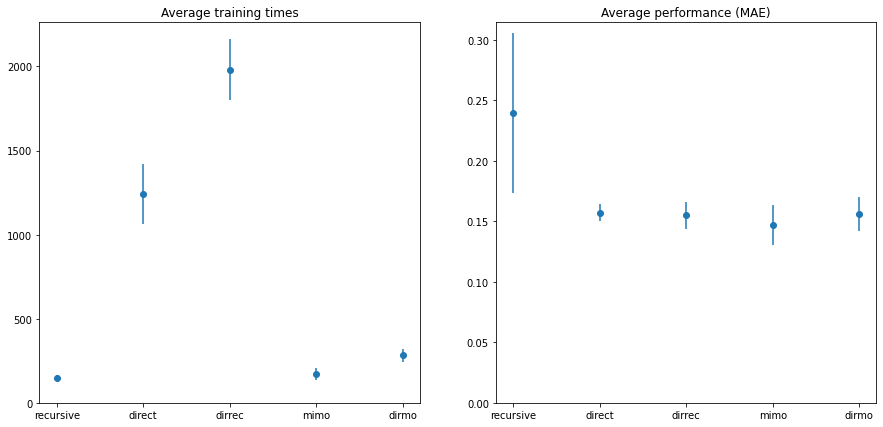

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

ax0.errorbar(methods, times_res, times_var_res, linestyle='None', fmt='o')
ax0.set_ylim(bottom=0)
ax0.set_title('Average training times')

ax1.errorbar(methods, performances_res, performances_var_res, linestyle='None', fmt='o')
ax1.set_ylim(bottom=0)
ax1.set_title('Average performance (MAE)')

plt.show()